In [1]:
#pip install -r requirements.txt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import chardet

with open('sales_data2.csv', 'rb') as f:
    result = chardet.detect(f.read())
    detected_encoding = result['encoding']
    print(f"Detected encoding: {detected_encoding}")

df = pd.read_csv('sales_data2.csv', encoding=detected_encoding)
df.to_csv('sales_data2.csv', encoding='utf-8', index=False)

df = pd.read_csv('sales_data2.csv', encoding='utf-8')

df.head()

Detected encoding: utf-8


,Order Date,Order ID,Product,Product_ean,catégorie,Purchase Address,Quantity Ordered,Price Each,Cost price,turnover,margin
0,2019-01-22 21:25:00,141234,iPhone,5.638009e+12,Vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000
1,2019-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,Alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750
2,2019-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,Vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900
3,2019-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,Sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965
4,2019-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,Électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950


In [3]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['MONTH'] = df['Order Date'].dt.month
df['DAY'] = df['Order Date'].dt.day
df['YEAR'] = df['Order Date'].dt.year
df['TIME'] = df['Order Date'].dt.time

# Create automated index for categories amb mapping explícit
category_codes, category_uniques = pd.factorize(df['catégorie'])
df['CATEGORY_ID'] = category_codes + 1
category_mapping = {cat: idx + 1 for idx, cat in enumerate(category_uniques)}
print(f"Category Mapping: {category_mapping}")

# Create automated index for products amb mapping explícit
product_codes, product_uniques = pd.factorize(df['Product'])
df['PRODUCT_ID'] = product_codes + 1
product_mapping = {prod: idx + 1 for idx, prod in enumerate(product_uniques)}
print(f"Product Mapping ({len(product_mapping)} productes): {list(product_mapping.keys())[:5]}...")

# Drop the Product_ean column if it exists
if 'Product_ean' in df.columns:
    df = df.drop('Product_ean', axis=1)

df

Category Mapping: {'Vêtements': 1, 'Alimentation': 2, 'Sports': 3, 'Électronique': 4}
Product Mapping (19 productes): ['iPhone', 'Lightning Charging Cable', 'Wired Headphones', '27in FHD Monitor', 'AAA Batteries (4-pack)']...


,Order Date,Order ID,Product,catégorie,Purchase Address,Quantity Ordered,Price Each,Cost price,turnover,margin,MONTH,DAY,YEAR,TIME,CATEGORY_ID,PRODUCT_ID
0,2019-01-22 21:25:00,141234,iPhone,Vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000,1,22,2019,21:25:00,1,1
1,2019-01-28 14:15:00,141235,Lightning Charging Cable,Alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750,1,28,2019,14:15:00,2,2
2,2019-01-17 13:33:00,141236,Wired Headphones,Vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900,1,17,2019,13:33:00,1,3
3,2019-01-05 20:33:00,141237,27in FHD Monitor,Sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965,1,5,2019,20:33:00,3,4
4,2019-01-25 11:59:00,141238,Wired Headphones,Électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950,1,25,2019,11:59:00,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185945,2019-12-11 20:58:00,319666,Lightning Charging Cable,Électronique,"14 Madison St, San Francisco, CA 94016",1,14.95,7.4750,14.95,7.4750,12,11,2019,20:58:00,4,2
185946,2019-12-01 12:01:00,319667,AA Batteries (4-pack),Électronique,"549 Willow St, Los Angeles, CA 90001",2,3.84,1.9200,7.68,3.8400,12,1,2019,12:01:00,4,13
185947,2019-12-09 06:43:00,319668,Vareebadd Phone,Alimentation,"273 Wilson St, Seattle, WA 98101",1,400.00,132.0000,400.00,268.0000,12,9,2019,06:43:00,2,12
185948,2019-12-03 10:39:00,319669,Wired Headphones,Alimentation,"778 River St, Dallas, TX 75001",1,11.99,5.9950,11.99,5.9950,12,3,2019,10:39:00,2,3


In [4]:
# Xarxa Neuronal amb TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Preparar les dades
df_nn = df.copy()

# Drop les columnes categòriques originals ja que tenim IDs
df_nn = df_nn.drop(['catégorie', 'Product'], axis=1)

# Encode columnes categòriques restants
categorical_cols_nn = df_nn.select_dtypes(include=['object']).columns
label_encoders_nn = {}
for col in categorical_cols_nn:
    le = LabelEncoder()
    df_nn[col] = le.fit_transform(df_nn[col].astype(str))
    label_encoders_nn[col] = le

# Separar features i target
X_nn = df_nn.drop(['turnover', 'margin', 'Order Date'], axis=1)
y_nn = df_nn['turnover']

# Split train/test
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

# Normalitzar les dades (important per xarxes neuronals!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nn)
X_test_scaled = scaler.transform(X_test_nn)

print(f"Nombre de features: {X_train_scaled.shape[1]}")
print(f"Train samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")


Nombre de features: 11
Train samples: 148760
Test samples: 37190


In [5]:
# Crear el model de Xarxa Neuronal
model_nn = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # Output layer per regressió
])

# Compilar el model
model_nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Veure l'arquitectura del model
model_nn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Entrenar el model
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Reduït a 5 per evitar overfitting
    restore_best_weights=True
)

# ReduceLROnPlateau: redueix learning rate quan val_loss no millora
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,      # Redueix LR a la meitat
    patience=3,      # Després de 3 epochs sense millora
    min_lr=0.00001   # LR mínim
)

history = model_nn.fit(
    X_train_scaled, y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 6172.6572 - mae: 31.4110 - mse: 6172.6572 - val_loss: 324.4001 - val_mae: 9.6050 - val_mse: 324.4001 - learning_rate: 0.0010
Epoch 2/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 6172.6572 - mae: 31.4110 - mse: 6172.6572 - val_loss: 324.4001 - val_mae: 9.6050 - val_mse: 324.4001 - learning_rate: 0.0010
Epoch 2/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2294.7061 - mae: 21.0713 - mse: 2294.7061 - val_loss: 300.1090 - val_mae: 10.1873 - val_mse: 300.1090 - learning_rate: 0.0010
Epoch 3/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2294.7061 - mae: 21.0713 - mse: 2294.7061 - val_loss: 300.1090 - val_mae: 10.1873 - val_mse: 300.1090 - learning_rate: 0.0010
Epoch 3/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2001.4413 - mae: 19.0345 - mse: 2001.4413 - val_loss: 311.5422 - val_mae: 8.8914 - val_mse: 311.5422 - learning_rate: 0.0010
Epoch 4/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step -

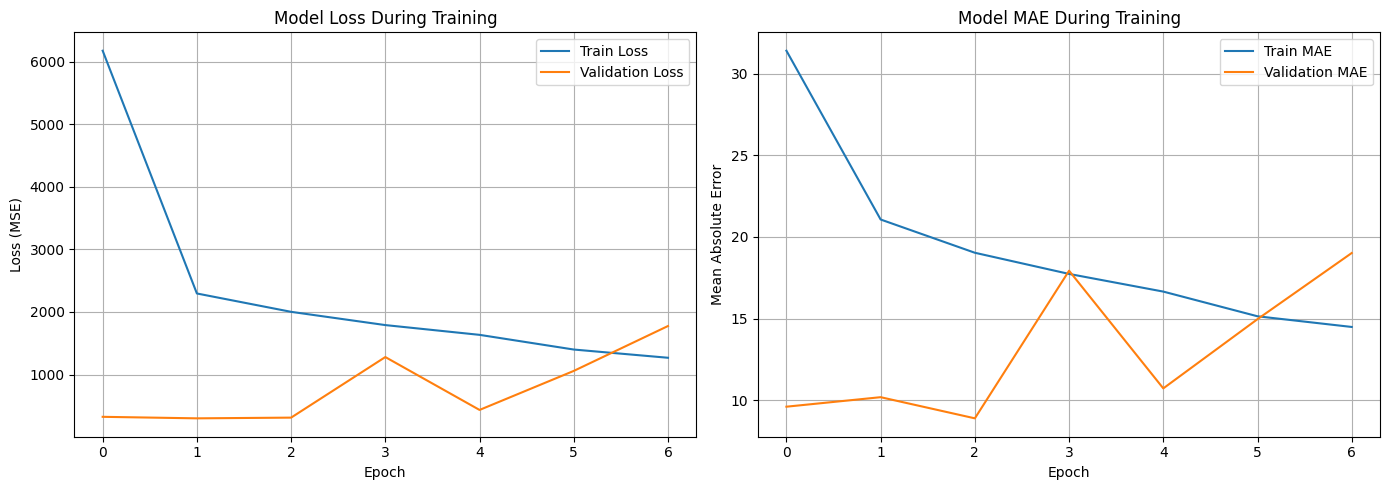

In [7]:
# Visualitzar el procés d'entrenament
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss During Training')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Model MAE During Training')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Avaluar el model
y_pred_nn = model_nn.predict(X_test_scaled).flatten()

# Calcular mètriques
mse_nn = mean_squared_error(y_test_nn, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
mae_nn = mean_absolute_error(y_test_nn, y_pred_nn)
r2_nn = r2_score(y_test_nn, y_pred_nn)

print("=" * 50)
print("XARXA NEURONAL - Resultats")
print("=" * 50)
print(f'MSE:  {mse_nn:.2f}')
print(f'RMSE: {rmse_nn:.2f}')
print(f'MAE:  {mae_nn:.2f}')
print(f'R² Score: {r2_nn:.4f}')
print("=" * 50)


1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step
XARXA NEURONAL - Resultats
MSE:  393.06
RMSE: 19.83
MAE:  10.32
R² Score: 0.9965
XARXA NEURONAL - Resultats
MSE:  393.06
RMSE: 19.83
MAE:  10.32
R² Score: 0.9965


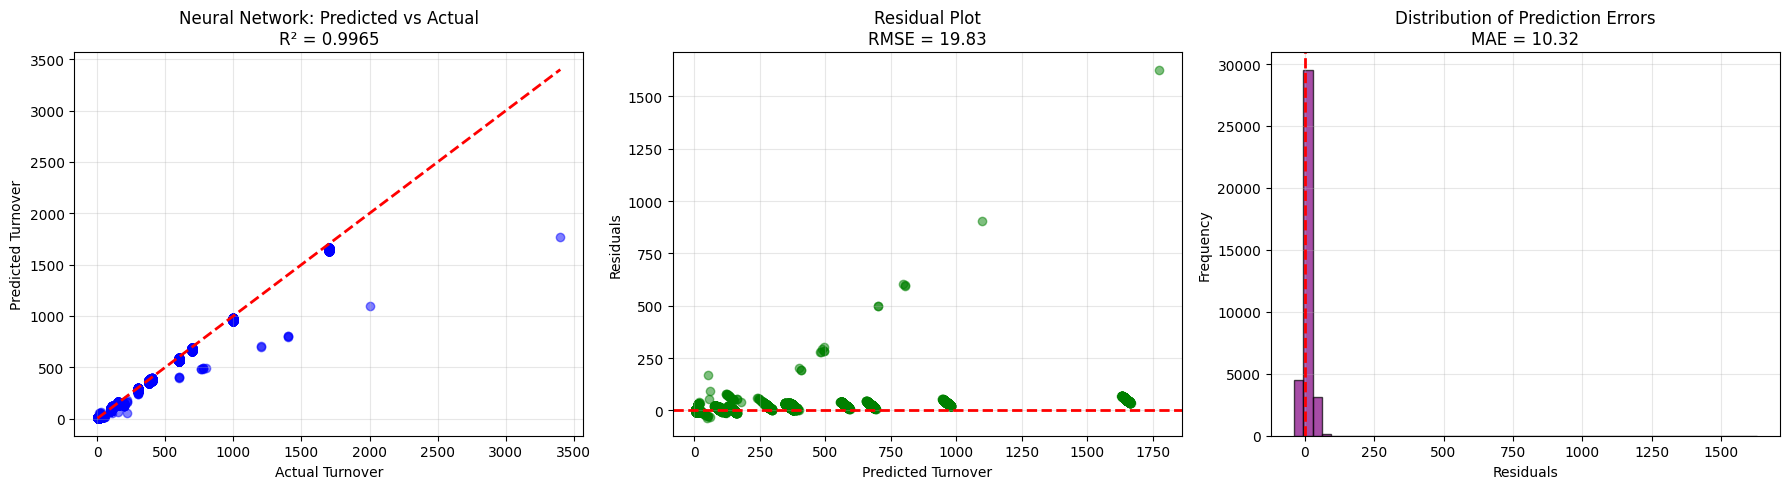

In [9]:
# Visualitzar resultats de la Xarxa Neuronal
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Predicted vs Actual
axes[0].scatter(y_test_nn, y_pred_nn, alpha=0.5, color='blue')
axes[0].plot([y_test_nn.min(), y_test_nn.max()], [y_test_nn.min(), y_test_nn.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Turnover')
axes[0].set_ylabel('Predicted Turnover')
axes[0].set_title(f'Neural Network: Predicted vs Actual\nR² = {r2_nn:.4f}')
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals
residuals_nn = y_test_nn - y_pred_nn
axes[1].scatter(y_pred_nn, residuals_nn, alpha=0.5, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Turnover')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'Residual Plot\nRMSE = {rmse_nn:.2f}')
axes[1].grid(True, alpha=0.3)

# Plot 3: Distribution of Errors
axes[2].hist(residuals_nn, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Distribution of Prediction Errors\nMAE = {mae_nn:.2f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# ============================================
# VERIFICACIÓ D'OVERFITTING
# ============================================
# L'overfitting passa quan el model memoritza les dades d'entrenament
# però no generalitza bé a dades noves (test/validació)

final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
best_epoch = np.argmin(history.history['val_loss']) + 1
total_epochs = len(history.history['loss'])

# Calcular la diferència relativa entre train i val loss
loss_ratio = final_val_loss / final_train_loss

print("=" * 60)
print("DIAGNÒSTIC D'OVERFITTING")
print("=" * 60)
print(f"Epochs entrenats: {total_epochs}")
print(f"Millor epoch (menor val_loss): {best_epoch}")
print(f"Train Loss final: {final_train_loss:.4f}")
print(f"Validation Loss final: {final_val_loss:.4f}")
print(f"Ràtio Val/Train Loss: {loss_ratio:.2f}")
print("-" * 60)

if loss_ratio > 1.5:
    print("⚠️  ALERTA: Possible OVERFITTING detectat!")
    print("   El model funciona molt millor en train que en validation.")
    print("   Recomanacions: Reduir complexitat, augmentar dropout, més dades.")
elif loss_ratio > 1.2:
    print("⚡ AVÍS: Lleuger overfitting.")
    print("   El model podria beneficiar-se de més regularització.")
else:
    print("✅ MODEL SA: No hi ha signes significatius d'overfitting.")
    print("   Les pèrdues train i validation són similars.")

print("=" * 60)

# Mostrar si early stopping va actuar
if total_epochs < 100:
    print(f"ℹ️  Early stopping va aturar l'entrenament a l'epoch {total_epochs}")
    print(f"   Els pesos restaurats són de l'epoch {best_epoch}")
else:
    print("ℹ️  L'entrenament va completar tots els 100 epochs")

DIAGNÒSTIC D'OVERFITTING
Epochs entrenats: 7
Millor epoch (menor val_loss): 2
Train Loss final: 1267.7236
Validation Loss final: 1774.6913
Ràtio Val/Train Loss: 1.40
------------------------------------------------------------
⚡ AVÍS: Lleuger overfitting.
   El model podria beneficiar-se de més regularització.
ℹ️  Early stopping va aturar l'entrenament a l'epoch 7
   Els pesos restaurats són de l'epoch 2


In [11]:
# ============================================
# GUARDAR MODEL I PREPROCESSADORS
# ============================================
# Per poder fer prediccions futures, necessitem guardar:
# 1. El model entrenat (arquitectura + pesos)
# 2. L'scaler (per normalitzar noves dades amb els mateixos paràmetres)
# 3. Els label encoders (per codificar categories igual que en entrenament)
# 4. Els mappings de categories i productes

import joblib
import os

# Crear carpeta models/ si no existeix
os.makedirs('models', exist_ok=True)

# 1. Guardar el model Keras
model_nn.save('models/sales_model.keras')
print("✅ Model guardat: models/sales_model.keras")

# 2. Guardar l'scaler
joblib.dump(scaler, 'models/scaler.pkl')
print("✅ Scaler guardat: models/scaler.pkl")

# 3. Guardar els label encoders
joblib.dump(label_encoders_nn, 'models/label_encoders.pkl')
print("✅ Label Encoders guardats: models/label_encoders.pkl")

# 4. Guardar mappings i informació addicional
mappings = {
    'category_mapping': category_mapping,
    'product_mapping': product_mapping,
    'feature_columns': list(X_nn.columns),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_metrics': {
        'mse': float(mse_nn),
        'rmse': float(rmse_nn),
        'mae': float(mae_nn),
        'r2': float(r2_nn)
    }
}
joblib.dump(mappings, 'models/mappings.pkl')
print("✅ Mappings guardats: models/mappings.pkl")

# 5. Guardar estadístiques per producte (mitjanes per prediccions futures)
product_stats = df.groupby('Product').agg({
    'Price Each': 'mean',
    'Cost price': 'mean',
    'Quantity Ordered': 'mean',
    'catégorie': 'first',
    'CATEGORY_ID': 'first',
    'PRODUCT_ID': 'first'
}).reset_index()
product_stats.to_csv('models/product_stats.csv', index=False)
print("✅ Estadístiques per producte guardades: models/product_stats.csv")

print("\n" + "=" * 60)
print("TOTS ELS COMPONENTS GUARDATS CORRECTAMENT!")
print("=" * 60)
print("\nFitxers creats a la carpeta 'models/':")
for f in os.listdir('models'):
    size = os.path.getsize(f'models/{f}') / 1024
    print(f"   📁 {f} ({size:.1f} KB)")

✅ Model guardat: models/sales_model.keras
✅ Scaler guardat: models/scaler.pkl
✅ Label Encoders guardats: models/label_encoders.pkl
✅ Mappings guardats: models/mappings.pkl
✅ Estadístiques per producte guardades: models/product_stats.csv

TOTS ELS COMPONENTS GUARDATS CORRECTAMENT!

Fitxers creats a la carpeta 'models/':
   📁 label_encoders.pkl (5043.1 KB)
   📁 mappings.pkl (0.8 KB)
   📁 product_stats.csv (1.3 KB)
   📁 sales_model.keras (186.6 KB)
   📁 scaler.pkl (1.2 KB)


In [12]:
# ============================================
# GENERAR PREDICCIONS DIÀRIES - PRÒXIMS 10 ANYS
# ============================================
# Crearem prediccions per cada producte per cada dia dels pròxims 10 anys
# Usant les mitjanes històriques de cada producte

# Carregar el model i preprocessadors (simulant un ús futur)
loaded_model = keras.models.load_model('models/sales_model.keras')
loaded_scaler = joblib.load('models/scaler.pkl')
loaded_encoders = joblib.load('models/label_encoders.pkl')
loaded_mappings = joblib.load('models/mappings.pkl')
product_stats = pd.read_csv('models/product_stats.csv')

print("✅ Model i preprocessadors carregats correctament!")
print(f"Features esperades: {loaded_mappings['feature_columns']}")

# Generar dates pels pròxims 10 anys (des de 2020)
start_date = '2020-01-01'
end_date = '2029-12-31'
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
print(f"\n📅 Generant prediccions des de {start_date} fins {end_date}")
print(f"   Total dies: {len(future_dates)}")

✅ Model i preprocessadors carregats correctament!
Features esperades: ['Order ID', 'Purchase Address', 'Quantity Ordered', 'Price Each', 'Cost price', 'MONTH', 'DAY', 'YEAR', 'TIME', 'CATEGORY_ID', 'PRODUCT_ID']

📅 Generant prediccions des de 2020-01-01 fins 2029-12-31
   Total dies: 3653


In [13]:
# Crear DataFrame amb totes les combinacions data x producte
predictions_list = []

# Obtenir la primera adreça codificada (usarem un valor representatiu)
# En un cas real, podries fer prediccions per cada ciutat
sample_address_encoded = df_nn['Purchase Address'].mode()[0]
sample_order_id = df_nn['Order ID'].median()
sample_time_encoded = df_nn['TIME'].mode()[0]

print("Generant prediccions per cada producte i dia...")
print("=" * 60)

for _, product_row in product_stats.iterrows():
    product_name = product_row['Product']
    
    # Crear DataFrame per aquest producte amb totes les dates
    product_df = pd.DataFrame({
        'Order ID': sample_order_id,
        'Quantity Ordered': product_row['Quantity Ordered'],
        'Price Each': product_row['Price Each'],
        'Cost price': product_row['Cost price'],
        'Purchase Address': sample_address_encoded,
        'MONTH': future_dates.month,
        'DAY': future_dates.day,
        'YEAR': future_dates.year,
        'TIME': sample_time_encoded,
        'CATEGORY_ID': product_row['CATEGORY_ID'],
        'PRODUCT_ID': product_row['PRODUCT_ID']
    })
    
    # Assegurar l'ordre correcte de columnes
    product_df = product_df[loaded_mappings['feature_columns']]
    
    # Normalitzar i predir
    product_scaled = loaded_scaler.transform(product_df)
    product_predictions = loaded_model.predict(product_scaled, verbose=0).flatten()
    
    # Guardar resultats
    for i, (date, pred) in enumerate(zip(future_dates, product_predictions)):
        predictions_list.append({
            'Date': date,
            'Product': product_name,
            'Category': product_row['catégorie'],
            'Predicted_Turnover': max(0, pred)  # No permetem valors negatius
        })
    
    print(f"✅ {product_name}: {len(future_dates)} prediccions generades")

print("=" * 60)
print(f"Total prediccions generades: {len(predictions_list):,}")

Generant prediccions per cada producte i dia...
✅ 20in Monitor: 3653 prediccions generades
✅ 27in 4K Gaming Monitor: 3653 prediccions generades
✅ 27in FHD Monitor: 3653 prediccions generades
✅ 34in Ultrawide Monitor: 3653 prediccions generades
✅ AA Batteries (4-pack): 3653 prediccions generades
✅ AAA Batteries (4-pack): 3653 prediccions generades
✅ Apple Airpods Headphones: 3653 prediccions generades
✅ Bose SoundSport Headphones: 3653 prediccions generades
✅ Flatscreen TV: 3653 prediccions generades
✅ Google Phone: 3653 prediccions generades
✅ LG Dryer: 3653 prediccions generades
✅ LG Washing Machine: 3653 prediccions generades
✅ Lightning Charging Cable: 3653 prediccions generades
✅ Macbook Pro Laptop: 3653 prediccions generades
✅ ThinkPad Laptop: 3653 prediccions generades
✅ USB-C Charging Cable: 3653 prediccions generades
✅ Vareebadd Phone: 3653 prediccions generades
✅ Wired Headphones: 3653 prediccions generades
✅ iPhone: 3653 prediccions generades
Total prediccions generades: 69,4

In [14]:
# Crear DataFrame final i guardar
predictions_df = pd.DataFrame(predictions_list)

# Afegir columnes útils
predictions_df['Year'] = predictions_df['Date'].dt.year
predictions_df['Month'] = predictions_df['Date'].dt.month
predictions_df['Day'] = predictions_df['Date'].dt.day
predictions_df['DayOfWeek'] = predictions_df['Date'].dt.day_name()

# Guardar a CSV
predictions_df.to_csv('predictions_10years.csv', index=False)
print(f"✅ Prediccions guardades a: predictions_10years.csv")
print(f"   Mida del fitxer: {os.path.getsize('predictions_10years.csv') / (1024*1024):.2f} MB")

# Mostrar resum
print("\n" + "=" * 60)
print("RESUM DE PREDICCIONS")
print("=" * 60)
print(predictions_df.head(20))
print(f"\n📊 Estadístiques de Turnover Predit:")
print(predictions_df['Predicted_Turnover'].describe())

✅ Prediccions guardades a: predictions_10years.csv
   Mida del fitxer: 4.67 MB

RESUM DE PREDICCIONS
         Date       Product      Category  Predicted_Turnover  Year  Month  \
0  2020-01-01  20in Monitor  Alimentation           57.566017  2020      1   
1  2020-01-02  20in Monitor  Alimentation           57.494793  2020      1   
2  2020-01-03  20in Monitor  Alimentation           57.423584  2020      1   
3  2020-01-04  20in Monitor  Alimentation           57.352367  2020      1   
4  2020-01-05  20in Monitor  Alimentation           57.281143  2020      1   
5  2020-01-06  20in Monitor  Alimentation           57.209965  2020      1   
6  2020-01-07  20in Monitor  Alimentation           57.139362  2020      1   
7  2020-01-08  20in Monitor  Alimentation           57.068771  2020      1   
8  2020-01-09  20in Monitor  Alimentation           56.998158  2020      1   
9  2020-01-10  20in Monitor  Alimentation           56.927570  2020      1   
10 2020-01-11  20in Monitor  Alimentation

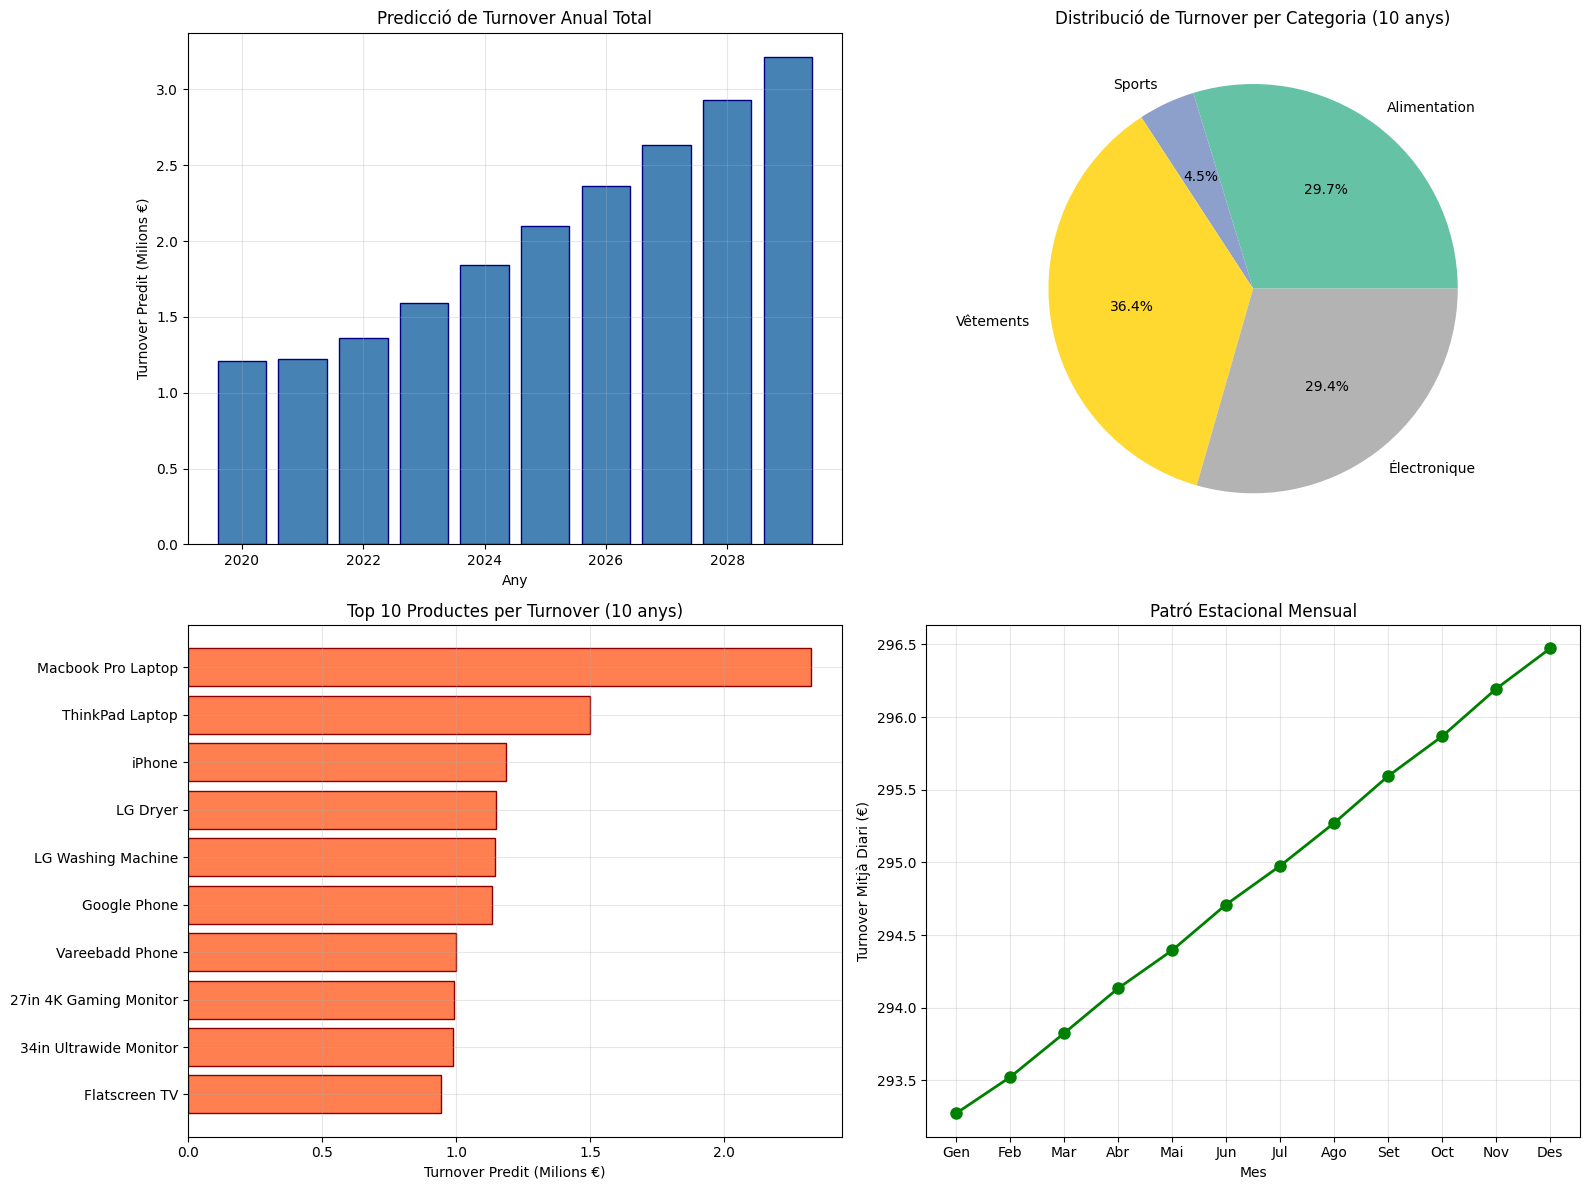


✅ Gràfic guardat a: predictions_visualization.png


In [15]:
# ============================================
# VISUALITZACIÓ DE PREDICCIONS
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Prediccions agregades per any
yearly_pred = predictions_df.groupby('Year')['Predicted_Turnover'].sum()
axes[0, 0].bar(yearly_pred.index, yearly_pred.values / 1e6, color='steelblue', edgecolor='navy')
axes[0, 0].set_xlabel('Any')
axes[0, 0].set_ylabel('Turnover Predit (Milions €)')
axes[0, 0].set_title('Predicció de Turnover Anual Total')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Prediccions per categoria
category_pred = predictions_df.groupby('Category')['Predicted_Turnover'].sum()
colors = plt.cm.Set2(np.linspace(0, 1, len(category_pred)))
axes[0, 1].pie(category_pred.values, labels=category_pred.index, autopct='%1.1f%%', colors=colors)
axes[0, 1].set_title('Distribució de Turnover per Categoria (10 anys)')

# Plot 3: Top 10 productes per turnover predit
product_pred = predictions_df.groupby('Product')['Predicted_Turnover'].sum().sort_values(ascending=True).tail(10)
axes[1, 0].barh(product_pred.index, product_pred.values / 1e6, color='coral', edgecolor='darkred')
axes[1, 0].set_xlabel('Turnover Predit (Milions €)')
axes[1, 0].set_title('Top 10 Productes per Turnover (10 anys)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Patró mensual (mitjana de tots els anys)
monthly_pred = predictions_df.groupby('Month')['Predicted_Turnover'].mean()
axes[1, 1].plot(monthly_pred.index, monthly_pred.values, 'o-', linewidth=2, markersize=8, color='green')
axes[1, 1].set_xlabel('Mes')
axes[1, 1].set_ylabel('Turnover Mitjà Diari (€)')
axes[1, 1].set_title('Patró Estacional Mensual')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(['Gen', 'Feb', 'Mar', 'Abr', 'Mai', 'Jun', 
                            'Jul', 'Ago', 'Set', 'Oct', 'Nov', 'Des'])
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gràfic guardat a: predictions_visualization.png")